# Importing all the necessary Libraries

In [ ]:
# Listing all the required imports in this cell

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from transformers import TextStreamer
import matplotlib.pyplot as plt
from ast import keyword
from io import BytesIO
from PIL import Image, ImageDraw
import numpy as np
import requests
import torch
import cv2
import os

[2024-12-13 15:57:36,643] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


# LLaVA MODEL

In [ ]:
model_directory = "4bit/llava-v1.5-13b-3GB"
model_config = {
    "device_map": "auto",
    "load_in_4bit": True,
    "quantization_config": BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type='nf4'
    )
}

In [ ]:
llava_model = LlavaLlamaForCausalLM.from_pretrained(model_directory, low_cpu_mem_usage=True, **model_config)
auto_tokenizer = AutoTokenizer.from_pretrained(model_directory, use_fast=False)
vision_module = llava_model.get_vision_tower()
if not vision_module.is_loaded:
    vision_module.load_model()
vision_module.to(device='cuda')
image_processor = vision_module.image_processor


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

# Defining all the necessary functions

In [ ]:
def generate_caption(image_path, prompt_text):
    """
    Generates a caption or instructions for an image using a pre-trained LLaVA model.

    Args:
        image_path (str): Path or URL to the image.
        prompt_text (str): Text prompt to guide the model's output.

    Returns:
        PIL.Image: Processed image.
        str: Model output text.
    """

    # Checking if the image path is a URL or a local file, if a URL, then
    # downloading it and loading it as an RGB image
    if image_path.startswith('http'):
        response = requests.get(image_path)
        input_image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        input_image = Image.open(image_path).convert('RGB')

    # Disbaling if there are any default initializations for PyTorch
    disable_torch_init()

    # Defining the conversation mode and getting the roles.
    conversation_mode = "llava_v0"
    conversation = conv_templates[conversation_mode].copy()
    roles = conversation.roles

    # Preprocessing the input image and prepare the input text prompt format
    image_tensor = image_processor.preprocess(input_image, return_tensors='pt')['pixel_values'].half().cuda()
    input_prompt = f"{roles[0]}: {prompt_text}"
    input_prompt = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + input_prompt

    # Appending the conversation messages to the model's input
    conversation.append_message(conversation.roles[0], input_prompt)
    conversation.append_message(conversation.roles[1], None)

    # Getting the full conversation prompt as input and tokenizing the conversation prompt
    raw_conversation_prompt = conversation.get_prompt()
    input_ids = tokenizer_image_token(raw_conversation_prompt, auto_tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    # Defining the stopping criteria for the model to stop generating output
    # When a special token is detected
    stop_sequence = conversation.sep if conversation.sep_style != SeparatorStyle.TWO else conversation.sep2
    stopping_criteria = KeywordsStoppingCriteria([stop_sequence], auto_tokenizer, input_ids)

    # Performing inference with the LLaVA model
    with torch.inference_mode():
        output_ids = llava_model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True, # Enabling sampling for randomness
            temperature=0.2, # Sampling temperature to control the randomness
            max_new_tokens=1024, # Maximum number of tokens the model can generate
            use_cache=True,
            stopping_criteria=[stopping_criteria] # Applying the stopping criteria to end generation
        )

    # Decoding the output text, updating the conversation with the generated text and
    # Cleaning the output text by removing any unwanted ending tokens.
    generated_text = auto_tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conversation.messages[-1][-1] = generated_text
    clean_output = generated_text.rsplit('</s>', 1)[0]

    return input_image, clean_output


from PIL import ImageDraw
def add_bounding_box(input_image, box_coordinates, outline_color="red", line_width=3):
    """
    Draws a bounding box on the given image.

    Args:
        input_image (PIL.Image): The image on which to draw the bounding box.
        box_coordinates (list): List of fractional coordinates [x_min, y_min, x_max, y_max].
        outline_color (str): Color of the bounding box.
        line_width (int): Width of the bounding box lines.

    Returns:
        PIL.Image: Image with the bounding box drawn.
    """
    # getting the dimensions of the input image and converting the fractional coordinates
    # as absolute pixel values
    img_width, img_height = input_image.size
    x_start = int(box_coordinates[0] * img_width)
    y_start = int(box_coordinates[1] * img_height)
    x_end = int(box_coordinates[2] * img_width)
    y_end = int(box_coordinates[3] * img_height)

    drawer = ImageDraw.Draw(input_image)
    drawer.rectangle([x_start, y_start, x_end, y_end], outline=outline_color, width=line_width)

    return input_image

In [ ]:
def remove_black_outline(object_image_path):
    """
    Removes the black outline around an object in the given image.

    Args:
        object_image_path (str): Path to the object image.

    Saves:
        A new image file with the black outline removed and transparency added.
    """
    original_image = cv2.imread(object_image_path)

    if original_image is None:
        print("Error: Image not found.")
        return

    print("Image loaded successfully.")

    # Converting the image to grayscale and creating a binary mask where black areas are 0
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(grayscale_image, 1, 255, cv2.THRESH_BINARY)

    # Applying a Gaussian blur to the mask to smooth the edges
    blurred_mask = cv2.GaussianBlur(binary_mask, (15, 15), 0)

    # Using the morphological operations to refine the mask
    morph_kernel = np.ones((5, 5), np.uint8)  # Kernel for morphology operations
    refined_mask = cv2.morphologyEx(blurred_mask, cv2.MORPH_CLOSE, morph_kernel)

    # Applying dilation to expand the mask and erosion to smoothen the mask edges
    expanded_mask = cv2.dilate(refined_mask, morph_kernel, iterations=1)
    smoothed_mask = cv2.erode(expanded_mask, morph_kernel, iterations=1)

    # Providing the final thresholding to ensure only the object remains
    _, final_binary_mask = cv2.threshold(smoothed_mask, 200, 255, cv2.THRESH_BINARY)

    # Converting the original image to BGRA (adding an alpha channel)
    image_with_alpha = cv2.cvtColor(original_image, cv2.COLOR_BGR2BGRA)
    image_with_alpha[:, :, 3] = final_binary_mask

    # Saving the result in ".png" format
    cv2.imwrite('object_no_black_outline.png', image_with_alpha)

In [ ]:
def overlay_object_on_background(background_image_path, object_image_path, bounding_box):
    """
    Places an object patch onto a background image based on bounding box coordinates.

    Args:
        background_image_path (str): Path to the background image.
        object_image_path (str): Path to the object patch image with transparency.
        bounding_box (list): Bounding box coordinates [x_min, y_min, x_max, y_max] in relative values.

    Returns:
        Image: Composite image with the object patch placed in the background.
    """
    # Loading the background and object patch images
    background_image = Image.open(background_image_path).convert("RGBA")
    object_image = Image.open(object_image_path).convert("RGBA")

    # Getting the bounding box dimensions in pixels
    bg_width, bg_height = background_image.size
    x_min = int(bounding_box[0] * bg_width)
    y_min = int(bounding_box[1] * bg_height)
    x_max = int(bounding_box[2] * bg_width)
    y_max = int(bounding_box[3] * bg_height)

    # Calculating the new size for the object patch, and resizing it to fit the bounding box
    object_width = x_max - x_min
    object_height = y_max - y_min
    resized_object_image = object_image.resize((object_width, object_height), Image.Resampling.LANCZOS)

    # Overlaying the object patch onto the background
    background_image.paste(resized_object_image, (x_min, y_min), resized_object_image)

    return background_image


In [29]:
def display_images_with_composite(background_image_path, object_patch_with_bg_path, object_patch_path, composite_image):
    """
    Display the background image, object patch with black outline, and object patch in the first row,
    and the composite image in the second row.

    Args:
        background_image_path (str): Path to the background image.
        object_patch_with_bg_path (str): Path to the object patch with black outline.
        object_patch_path (str): Path to the extracted object patch.
        composite_image (PIL.Image): The composite image to display.
    """
    # Loading images
    background_image = Image.open(background_image_path)
    object_patch_with_bg = Image.open(object_patch_with_bg_path)
    object_patch = Image.open(object_patch_path)

    # Converting composite_image (PIL) to numpy array for plotting and creating a grid layout
    composite_image_array = np.array(composite_image)
    fig = plt.figure(figsize=(18, 12))  # Adjusting figure size for additional subplot
    grid = plt.GridSpec(2, 4, height_ratios=[1, 2], width_ratios=[2, 1, 1, 1])

    # First row: Background image, object patch with black outline, and object patch
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.imshow(background_image)
    ax1.set_title("Scene Image")
    ax1.axis("off")

    ax2 = fig.add_subplot(grid[0, 2])
    ax2.imshow(object_patch_with_bg)
    ax2.set_title("Object Patch [with Outline]")
    ax2.axis("off")

    ax3 = fig.add_subplot(grid[0, 3])
    ax3.imshow(object_patch)
    ax3.set_title("Object Patch [without Outline]")
    ax3.axis("off")

    # Second row: Composite image spans across the full row
    ax4 = fig.add_subplot(grid[1, :])
    ax4.imshow(composite_image_array)
    ax4.set_title("Composite Image")
    ax4.axis("off")

    # Adjusting layout and spacing to avoid overlapping of the titles
    plt.tight_layout(pad=4.0)
    plt.subplots_adjust(top=0.9, bottom=0.1)

    plt.show()

# ADVANCE TASK Results

Generating Composite Images

Image loaded successfully.
[0.76, 0.2, 0.92, 0.47]


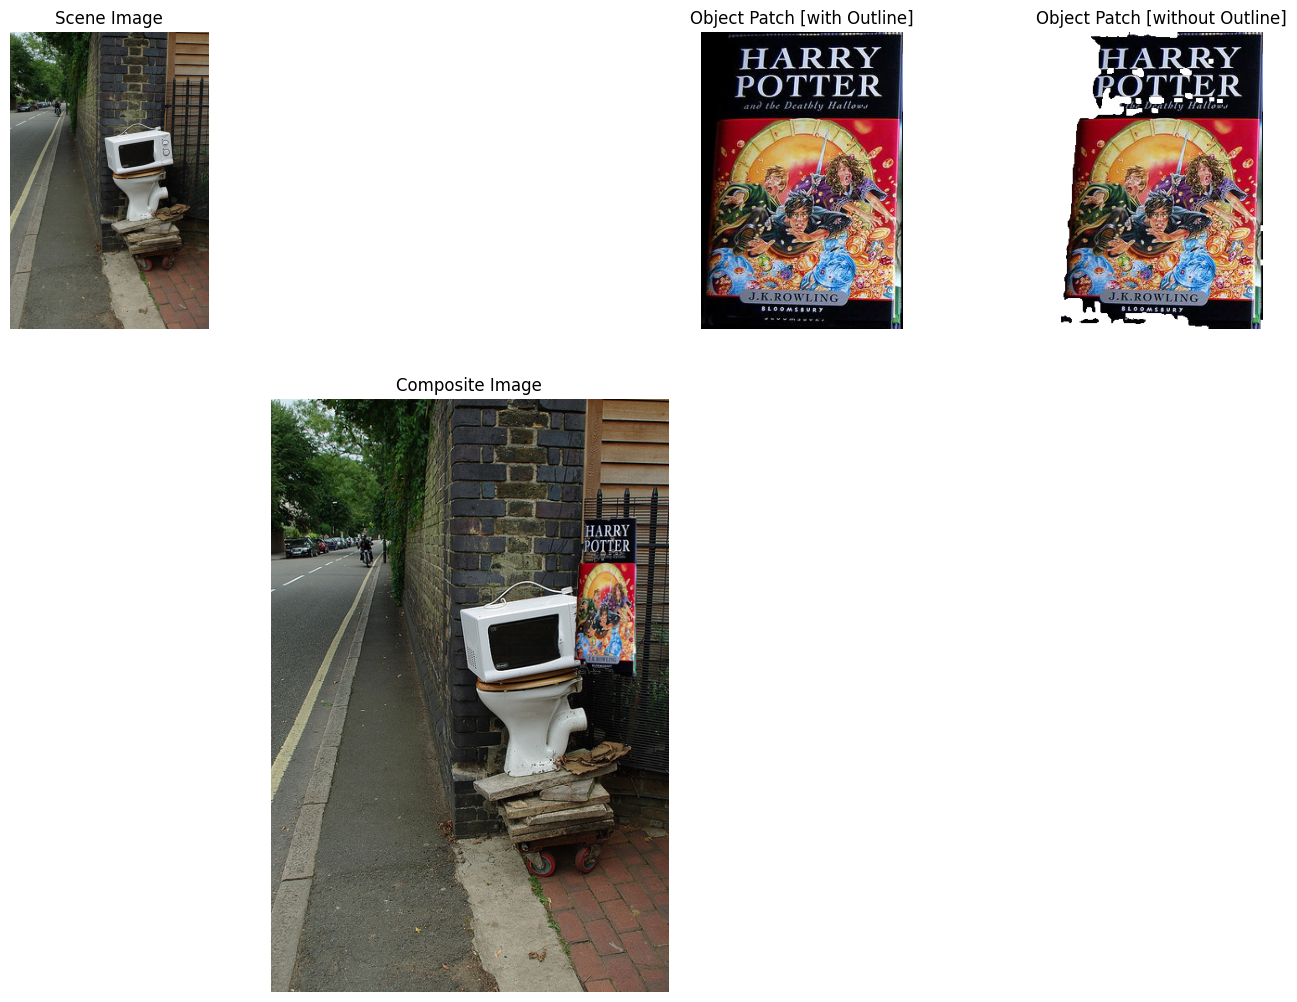

In [45]:
# Result I
background_path = "/dataset/scene_images/105547.jpg"  # Path to the background image
object_path_with_outline = "/dataset/object_patches/1137014.jpg"
remove_black_outline(object_path_with_outline)  # Removes black outline from the object image
object_path_without_outline = "object_no_black_outline.png"  # Path to the processed object image

image_with_caption, generated_caption = generate_caption(background_path, 'Give exact coordinates to place a book in the image')
print(generated_caption)  # Output bounding box coordinates
bounding_box_coords = eval(generated_caption)
composite_result = overlay_object_on_background(background_path, object_path_without_outline, bounding_box_coords)
display_images_with_composite(background_path, object_path_with_outline, object_path_without_outline, composite_result)

Image loaded successfully.
[0.0, 0.37, 0.32, 0.63]


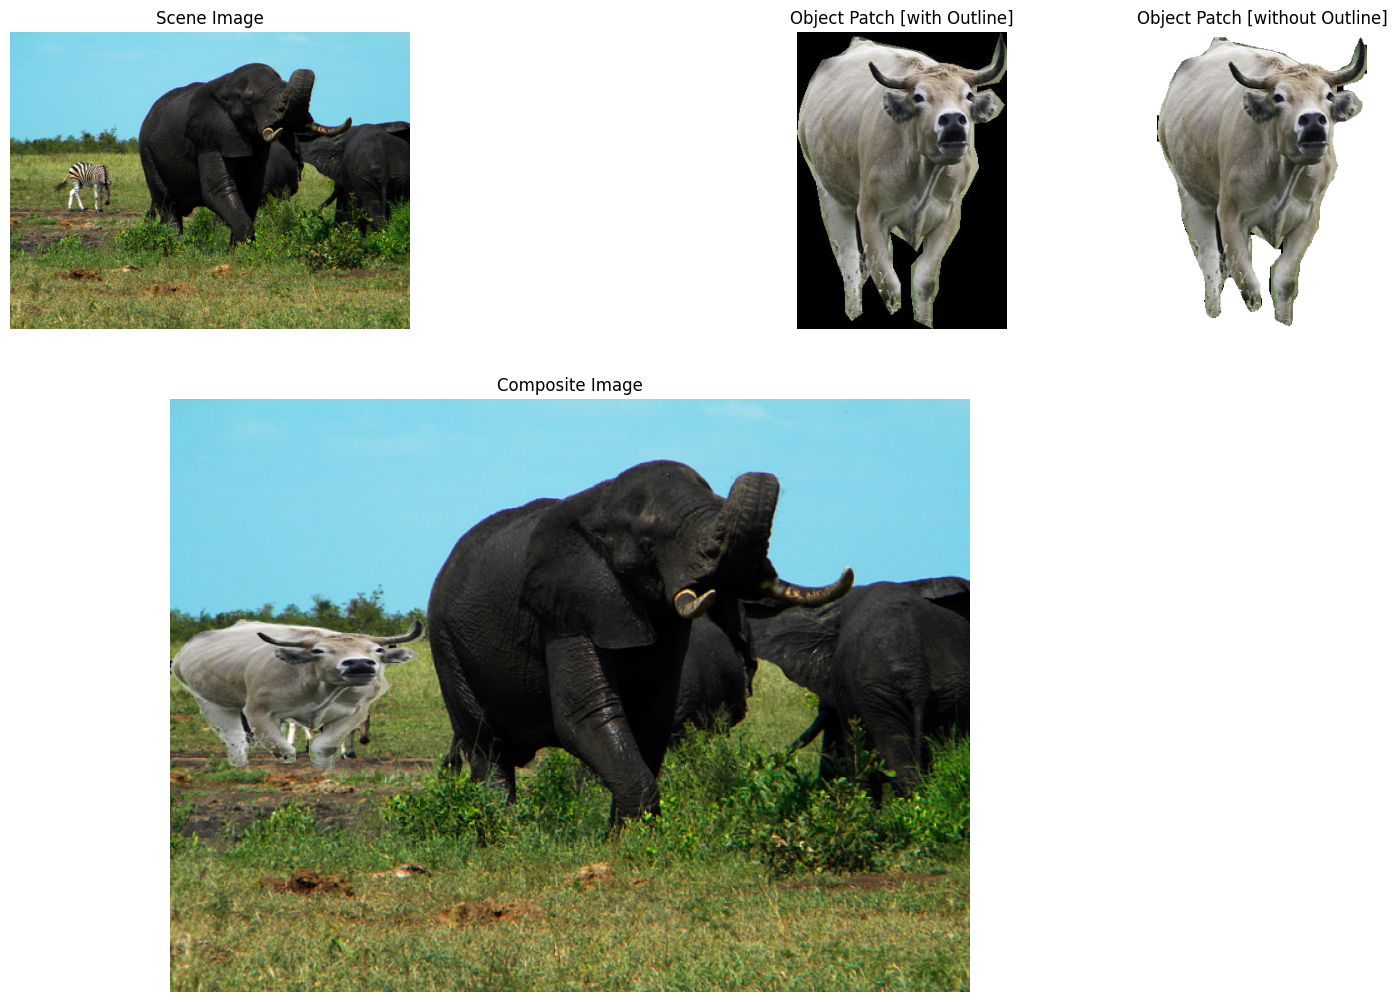

In [33]:
# Result II
background_path = "/dataset/scene_images/94538.jpg"  # Path to the background image
object_path_with_outline = "/dataset/object_patches/70157.jpg"
remove_black_outline(object_path_with_outline)  # Remove black outline from the object image
object_path_without_outline = "object_no_black_outline.png"  # Path to the processed object image

image_with_caption, generated_caption = generate_caption(background_path, 'Give exact coordinates to place a cow in the image')
print(generated_caption)  # Output bounding box coordinates
bounding_box_coords = eval(generated_caption)
composite_result = overlay_object_on_background(background_path, object_path_without_outline, bounding_box_coords)
display_images_with_composite(background_path, object_path_with_outline, object_path_without_outline, composite_result)


Image loaded successfully.
[0.47, 0.78, 0.62, 0.93]


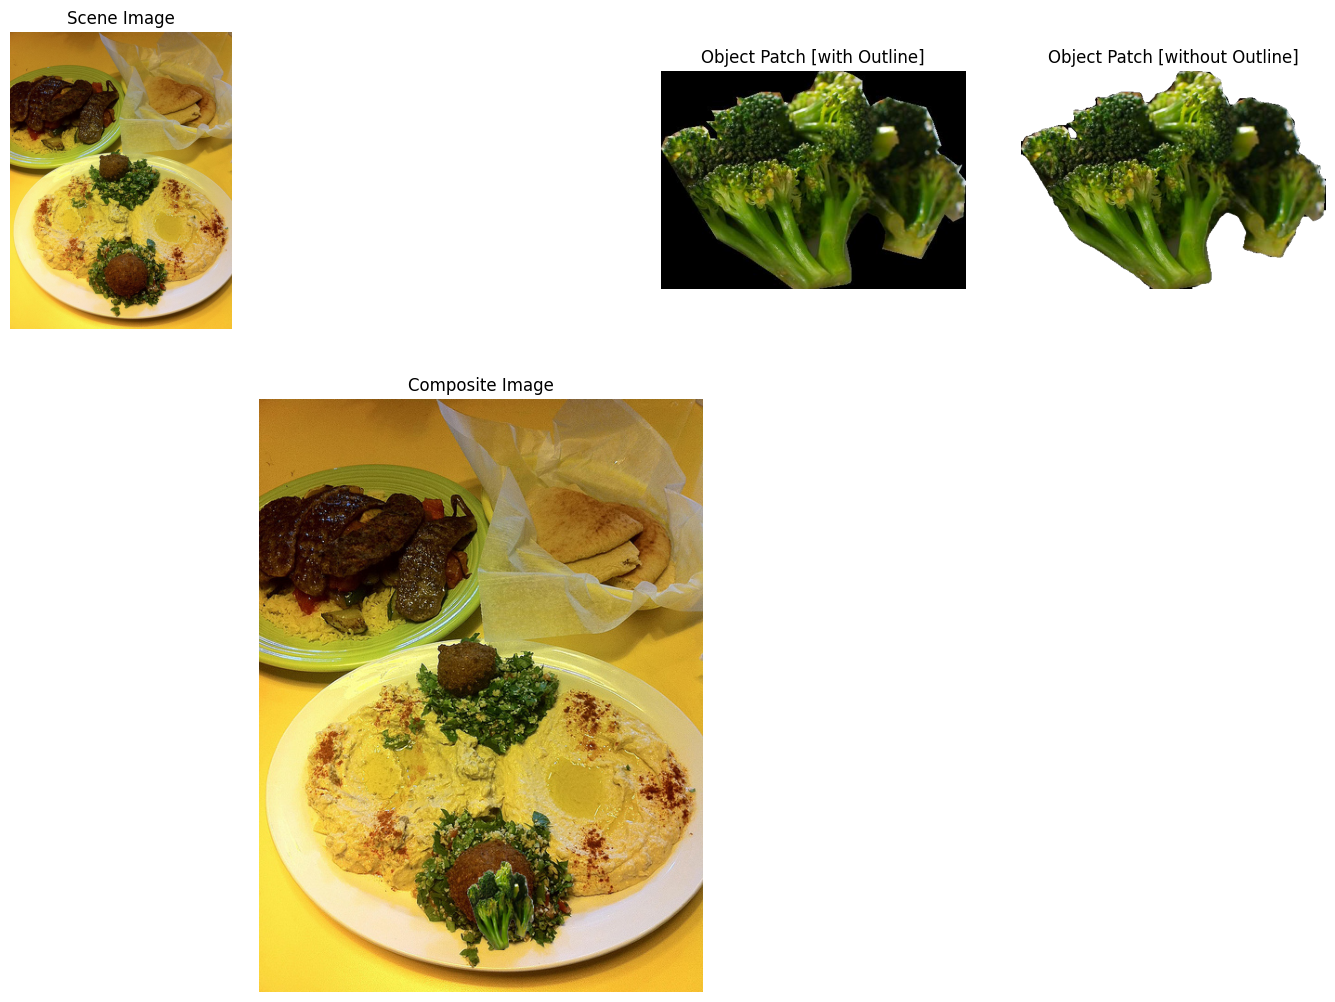

In [34]:
# Result III
background_path = "/dataset/scene_images/149295.jpg"  # Path to the background image
object_path_with_outline = "/dataset/object_patches/1055204.jpg"
remove_black_outline(object_path_with_outline)  # Remove black outline from the object image
object_path_without_outline = "object_no_black_outline.png"  # Path to the processed object image

image_with_caption, generated_caption = generate_caption(background_path, 'Give exact coordinates to place a broccoli in the image')
print(generated_caption)  # Output bounding box coordinates
bounding_box_coords = eval(generated_caption)
composite_result = overlay_object_on_background(background_path, object_path_without_outline, bounding_box_coords)
display_images_with_composite(background_path, object_path_with_outline, object_path_without_outline, composite_result)


Image loaded successfully.
[0.78, 0.29, 0.99, 0.54]


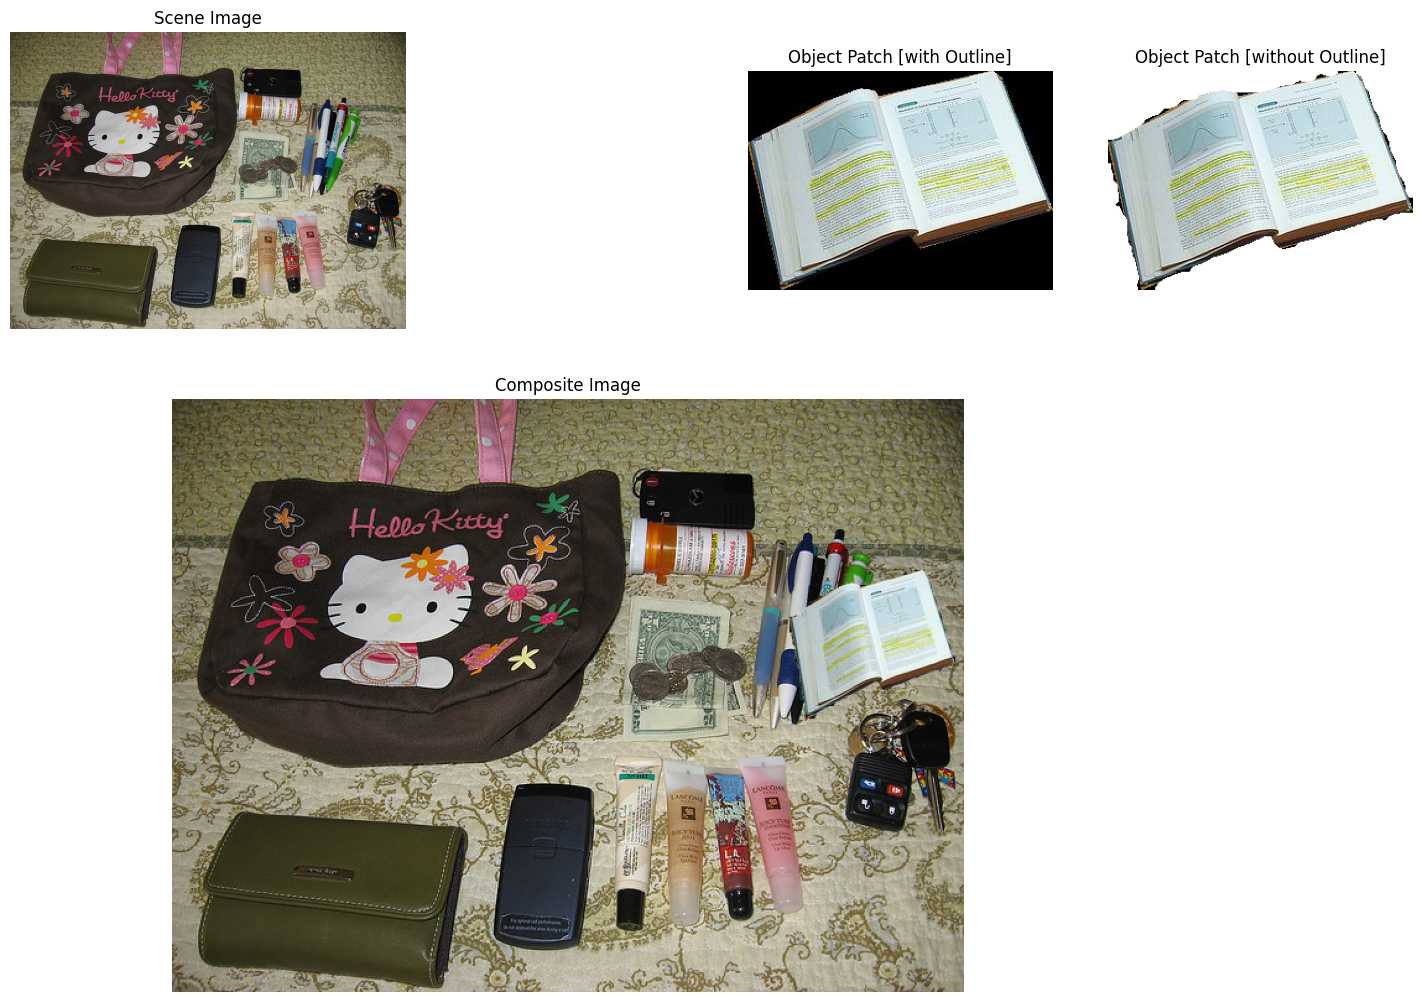

In [41]:
# Result IV
background_path = "/dataset/scene_images/65166.jpg"  # Path to the background image
object_path_with_outline = "/dataset/object_patches/1137907.jpg"
remove_black_outline(object_path_without_outline)  # Remove black outline from the object image
object_path_without_outline = "object_no_black_outline.png"  # Path to the processed object image

image_with_caption, generated_caption = generate_caption(background_path, 'Give exact coordinates to place a book in the image')
print(generated_caption)  # Output bounding box coordinates
bounding_box_coords = eval(generated_caption)
composite_result = overlay_object_on_background(background_path, object_path_without_outline, bounding_box_coords)
display_images_with_composite(background_path, object_path_with_outline, object_path_without_outline, composite_result)


Image loaded successfully.
[0.63, 0.29, 0.87, 0.59]


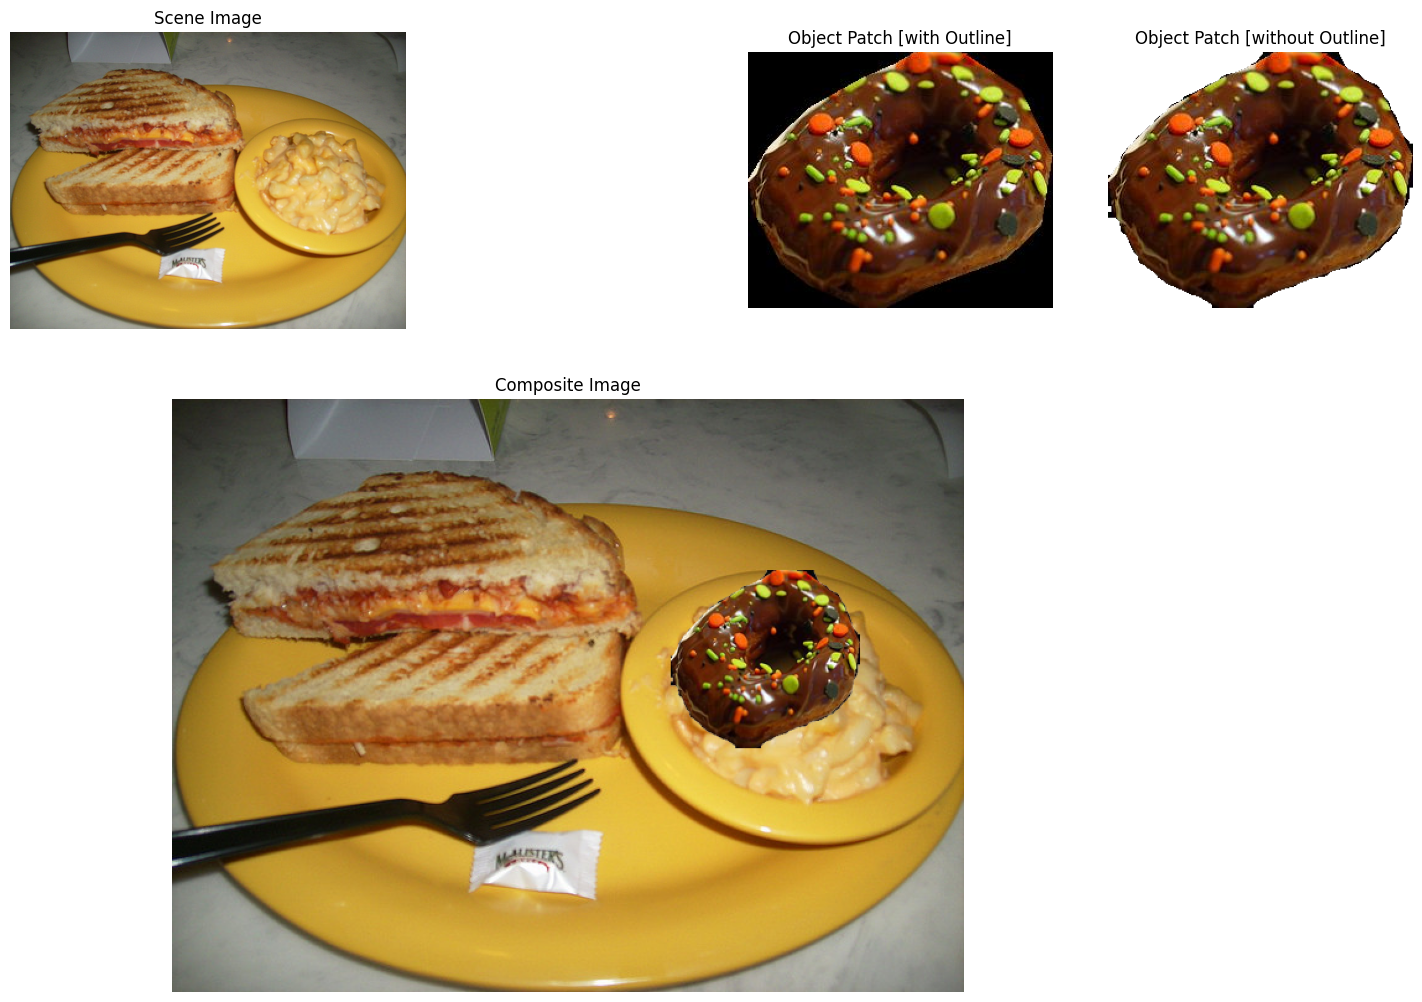

In [44]:
# Result V
background_path = "/dataset/scene_images/189646.jpg"  # Path to the background image
object_path_with_outline = "/dataset/object_patches/1079331.jpg"
remove_black_outline(object_path_with_outline)  # Remove black outline from the object image
object_path_without_outline = "object_no_black_outline.png"  # Path to the processed object image

image_with_caption, generated_caption = generate_caption(background_path, 'Give exact coordinates to place a donut in the image')
print(generated_caption)  # Output bounding box coordinates
bounding_box_coords = eval(generated_caption)
composite_result = overlay_object_on_background(background_path, object_path_without_outline, bounding_box_coords)
display_images_with_composite(background_path, object_path_with_outline, object_path_without_outline, composite_result)


# End of Advance Task Results